In [1]:
import netket
from flax.core.scope import CollectionFilter
from netket.utils.types import PyTree
from netket.operator import Squared
from functools import partial, lru_cache
from typing import Callable, Optional

import jax
from jax import numpy as jnp
from flax.core.scope import CollectionFilter, DenyList  # noqa: F401

import netket as nk
from netket import jax as nkjax
from netket.operator import DiscreteOperator, Squared
from netket.stats import Stats
from netket.utils.types import PyTree
from netket.utils.dispatch import dispatch

# from nektet.vqs import _ex
from netket.vqs import expect_and_grad, expect_and_forces
from netket.vqs.mc.common import force_to_grad
from netket.stats import Stats
import time
import json
import matplotlib.pyplot as plt
import numpy as np
from netket.operator.spin import sigmax, sigmay,sigmaz

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
# Define a 1d chain
L = 10
dis = 1
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
# ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
b=dis
a=-dis
Gamma = (b-a) * np.random.random_sample(L) + a

################################################################################
################################################################################
################################################################################
#이렇게 정의하는게 더 빨랑
ha = sum([ sigmax(hi,i)*sigmax(hi,(i+1)%L)
         + sigmay(hi,i)*sigmay(hi,(i+1)%L)
         + sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
           for i in range(L)])
################################################################################
################################################################################
################################################################################
ha = ha + sum([Gamma[i]*sigmaz(hi,i) for i in range(L)])

In [33]:
Et = np.random.uniform(low=0, high=L, size=None)
Et

4.386579145576057

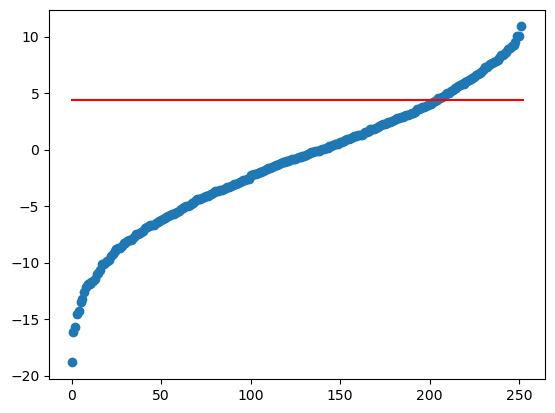

In [34]:
E, vec = np.linalg.eigh(ha.to_dense())
plt.scatter(range(len(E)),E)
plt.plot([0,len(E)],[Et,Et],'r')

In [36]:
ha_Et_inv  = np.linalg.inv((ha-Et).to_dense())
E_inv, vec_inv = np.linalg.eigh(ha_Et_inv)

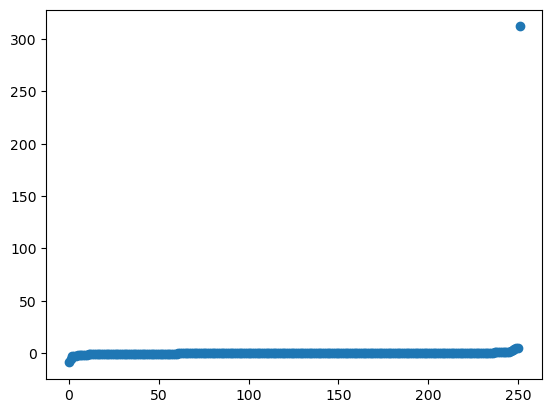

In [37]:
plt.scatter(range(len(E_inv)),E_inv)

In [38]:
E_inv
# -4.135835

array([-8.80510911e+00, -5.03416380e+00, -2.96532129e+00, -2.65236622e+00,
       -2.24869632e+00, -1.78297275e+00, -1.72044041e+00, -1.59824104e+00,
       -1.46434474e+00, -1.26923317e+00, -1.22116987e+00, -9.40222579e-01,
       -8.83791448e-01, -8.44771225e-01, -7.89220250e-01, -7.55170386e-01,
       -7.35753387e-01, -7.13615150e-01, -6.81078858e-01, -6.48770727e-01,
       -6.21888369e-01, -6.13181585e-01, -5.84573065e-01, -5.75904953e-01,
       -5.40083398e-01, -5.25283768e-01, -5.04090315e-01, -4.90815447e-01,
       -4.67415667e-01, -4.65264816e-01, -4.49801804e-01, -4.37755010e-01,
       -4.22886649e-01, -4.07577794e-01, -3.96532208e-01, -3.88186447e-01,
       -3.83671510e-01, -3.68903480e-01, -3.56623800e-01, -3.56352179e-01,
       -3.34982552e-01, -3.26668572e-01, -3.20510610e-01, -3.18443825e-01,
       -3.15828476e-01, -3.13137888e-01, -3.08458254e-01, -2.99214797e-01,
       -2.89602123e-01, -2.87964190e-01, -2.79917340e-01, -2.76255527e-01,
       -2.71001000e-01, -

In [39]:
def add(x,y):
    return x+y

In [40]:
@nk.vqs.expect.dispatch
def expect_try(vstate: nk.vqs.FullSumState, Ô: nk.operator.DiscreteOperator) -> Stats:  # noqa: F811
#     _check_hilbert(vstate, Ô)

#     O = sparsify(Ô)
    O = Ô.to_sparse()
    Ψ = vstate.to_array()

    # TODO: This performs the full computation on all MPI ranks.
    # It would be great if we could split the computation among ranks.

    OΨ = O @ Ψ
    expval_O = (Ψ.conj() * OΨ).sum() 

    variance = jnp.sum(jnp.abs(OΨ - expval_O * Ψ) ** 2)
    return Stats(mean=expval_O, error_of_mean=0.0, variance=variance)

In [41]:
O_sparse = ha.to_sparse()
H_Et_sparse = (ha-Et).to_sparse()
H_Et_squ_sparse = ((ha-Et)@(ha-Et)).to_sparse()

In [54]:
@expect_and_grad.dispatch
def expect_and_grad_fullsum(
    vstate: nk.vqs.FullSumState,
    Ô: nk.operator.DiscreteOperator,
    *args,
    mutable: CollectionFilter = False,
    use_covariance: Optional[bool] = None,
    **kwargs,
) -> tuple[Stats, PyTree]:
    if use_covariance is None:
        use_covariance = Ô.is_hermitian

    if use_covariance:
        # Implementation of expect_and_grad for `use_covariance == True` (due to the Literal[True]
        # type in the signature).` This case is equivalent to the composition of the
        # `expect_and_forces` and `force_to_grad` functions.
        # return expect_and_grad_from_covariance(vstate, Ô, *args, mutable=mutable)
        Ō, Ō_grad = expect_and_forces(vstate, Ô, *args, mutable=mutable, **kwargs)
        Ō_grad = force_to_grad(Ō_grad, vstate.parameters)
        return Ō, Ō_grad
    else:
        raise NotImplementedError(
            "The gradient of non hermitian operators with "
            "FullSumState is not yet implemented"
        )

@nk.vqs.expect_and_forces.dispatch
def expect_and_forces_fullsum(
    vstate: nk.vqs.FullSumState,
    Ô: nk.operator.DiscreteOperator,
    *,
    mutable: CollectionFilter = False,
) -> tuple[Stats, PyTree]:
    if isinstance(Ô, Squared):
        raise NotImplementedError("expect_and_forces not yet implemented for `Squared`")

#     _check_hilbert(vstate, Ô)
    

    O = O_sparse
    H_Et = H_Et_sparse
    H_Et_squ = H_Et_squ_sparse

    Ψ = vstate.to_array()
#     OΨ = O @ Ψ
    H_EtΨ = H_Et@Ψ
    H_Et_squΨ = H_Et_squ @ Ψ
    Ψ_pre = H_Et @ Ψ
    Ψ_pre = Ψ_pre / jnp.linalg.norm(Ψ_pre)
    H_EtΨ_pre = H_Et @ Ψ_pre
    invOΨ = ha_Et_inv @ Ψ
    Ψ_pre_conjO = Ψ_pre.conj() @ H_Et

    expval_O, Ō_grad, new_model_state = _exp_forces(
        vstate._apply_fun,
        mutable,
        vstate.parameters,
        vstate.model_state,
        vstate._all_states,
#         OΨ,
        Ψ,
        Ψ_pre,
        H_Et_squΨ,
        H_EtΨ,
        H_EtΨ_pre,
        invOΨ,
        Ψ_pre_conjO,
    )

    if mutable is not False:
        vstate.model_state = new_model_state

    return expval_O, Ō_grad

5
@partial(jax.jit, static_argnums=(0, 1))
def _exp_forces(
    model_apply_fun: Callable,
    mutable: CollectionFilter,
    parameters: PyTree,
    model_state: PyTree,
    σ: jnp.ndarray,
#     OΨ: jnp.ndarray,
    Ψ: jnp.ndarray,
    Ψ_pre: jnp.ndarray,
    H_Et_squΨ: jnp.ndarray,
    H_EtΨ: jnp.ndarray,
    H_EtΨ_pre: jnp.ndarray,
    invOΨ: jnp.ndarray,
    Ψ_pre_conjO: jnp.ndarray,
) -> tuple[PyTree, PyTree]:
    is_mutable = mutable is not False

#     expval_O = (Ψ.conj() * invOΨ).sum()
#     expval_O = (Ψ.conj() * OΨ).sum()
#     variance = jnp.sum(jnp.abs(OΨ - expval_O * Ψ) ** 2)
#     ΔOΨ = (OΨ - expval_O * Ψ).conj() * Ψ
    
    expval_H_Et_squ = (Ψ.conj() * H_Et_squΨ).sum()
    ΔOΨ_squ = (H_Et_squΨ - expval_H_Et_squ * Ψ).conj() * Ψ
    
    denom = Ψ_pre.conj()@Ψ
    expval_H_Et = (Ψ_pre.conj() * H_EtΨ).sum()/denom
    ΔOΨ_non = (Ψ_pre_conjO - expval_H_Et * Ψ_pre.conj())/denom * Ψ
#     ΔOΨ_non = (Ψ_pre_conjO - expval_H_Et * Ψ_pre.conj()) * Ψ
#     ΔOΨ_non = (H_EtΨ_pre - expval_H_Et * Ψ_pre).conj() * Ψ
    

    
    _, vjp_fun, *new_model_state = nkjax.vjp(
        lambda w: model_apply_fun({"params": w, **model_state}, σ, mutable=mutable),
        parameters,
        conjugate=True,
        has_aux=is_mutable,
    )

#     Ō_grad = vjp_fun(ΔOΨ)[0]
    Ō_grad_first = vjp_fun(ΔOΨ_squ)[0]
    Ō_grad_second = vjp_fun(-2*ΔOΨ_non)[0]
#     Ō_grad_second = vjp_fun(ΔOΨ_non)[0]
    
    Ō_grad = jax.tree_map(add, Ō_grad_first, Ō_grad_second)
#     Ō_grad = Ō_grad_first

    new_model_state = new_model_state[0] if is_mutable else None

    return (
        Stats(mean=1, error_of_mean=0.0, variance=0.0),
        Ō_grad,
        new_model_state,
    )

In [55]:
def variance(vsta, hamiltonian):
    return vsta.to_array().conj()@(hamiltonian@hamiltonian).to_sparse()@vsta.to_array() - (vsta.to_array().conj()@(hamiltonian).to_sparse()@vsta.to_array())**2

In [61]:
# Build the sampler
# sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)
epochs = 100000


ma = nk.models.RBM(alpha=3, param_dtype=complex)
vs = nk.vqs.FullSumState(hi, ma)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.001)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)


# The ground-state optimization loop
Target_ha = ha
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(epochs, out='RBM')
end = time.time()

data=json.load(open("RBM.log"))
# plt.plot(data['Energy']['Mean']['real'])
print("Energy : ", vs.to_array().conj().T@ha.to_sparse()@vs.to_array())
print("Et : ", Et)
print("Vaiance : ",variance(vs, ha).real)
# print("Variational result : ",data['Energy']['Mean']['real'][-1])
# print("Real result : ",E_inv[0])
# plt.plot(np.log10(data['Energy']['Variance']))

100%|█| 100000/100000 [1:13:56<00:00, 22.54it/s, Energy=1.000e+00 ± 0.000e+00 [σ


Energy :  (4.2031391079239855+1.1038533368618042e-17j)
Et :  4.386579145576057
Vaiance :  0.01612792394202245
